Graph Neural Network with NetworkX - StellarGraph 

Algorithm Selection for the Travelling Salesman Problem

In [ ]:
!pip install -q stellargraph

In [ ]:
import csv
import time 
import math
import random
import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as tf
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.layer import DeepGraphCNN,GAT
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification

from sklearn.datasets import load_files
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.neighbors import KDTree

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D,Conv2D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/GECCO-2022/selectedset.zip"


In [ ]:
def extractTSPparams(file_path):
  instance = []
  lines = []
  #problem data start at line 6
  start = 0
  with open(file_path) as f:
    lines = f.read().splitlines()
    #print(lines)
  for i in range(start, len(lines)-1):
    line = lines[i].split(",")
    instance.append([float(line[0]),float(line[1])])
  #print(instance)
  return instance

In [ ]:
import os
rootdir = '/content/CHRvsGREEDY/CHR/'
TSPinstances = []
TSPlabels = []
instances_num = 2500

for dir,subdir,files in os.walk(rootdir):
  for file in files[:instances_num]:

    file_path = os.path.join(rootdir, file)
    #print(file_path)
    instanceName = file[:-4]
    TSPinstance = (instanceName, extractTSPparams(file_path))
    #if TSPinstance[1] != []:
    if len(TSPinstance[1]) > 5:        
      TSPinstances.append(TSPinstance)
      TSPlabels.append(0)
    else:
      print(instanceName + " has no vertex!")

rootdir = '/content/CHRvsGREEDY/GREEDY/'

for dir,subdir, files in os.walk(rootdir):
  for file in files[:instances_num]:

    file_path = os.path.join(rootdir, file)
    
    instanceName = file[:-4]
    TSPinstance = (instanceName, extractTSPparams(file_path))
    #if TSPinstance[1] != []:  
    if len(TSPinstance[1]) > 5:           
      TSPinstances.append(TSPinstance)
      TSPlabels.append(1)
    else:
      print(instanceName + " has no vertex!")

In [ ]:
TSPlabels = pd.DataFrame(TSPlabels)
print(TSPlabels)

      0
0     0
1     0
2     0
3     0
4     0
...  ..
4971  1
4972  1
4973  1
4974  1
4975  1

[4976 rows x 1 columns]


In [ ]:
instancesG = []

counter = 0
for instance in TSPinstances:
  tempG = nx.Graph(name = instance[0])
  tree = KDTree(instance[1], leaf_size=2)  
  g = nx.Graph()
  for i in range(0,len(instance[1])): 
    tempG.add_node(i, coord=instance[1][i])
    dist, ind = tree.query([[instance[1][i][0],instance[1][i][1]]] , k=5)  
    for j in ind[0][1:]:
      distance = math.sqrt(((instance[1][i][0]-instance[1][j][0])**2)+((instance[1][i][1]-instance[1][j][1])**2))
      tempG.add_edge(i,j, weight=distance)
      tempG.add_edge(j,i, weight=distance)
    #for j in range(i,len(instance[1])):
      #distance = math.sqrt(((instance[1][i][0]-instance[1][j][0])**2)+((instance[1][i][1]-instance[1][j][1])**2))
      #tempG.add_edge(i,j, weight=1)
      #tempG.add_edge(j,i, weight=1)   
  
  SG = StellarGraph.from_networkx(tempG, node_features="coord")
  instancesG.append(SG)

generator = PaddedGraphGenerator(graphs=instancesG)
#ClusterNodeGenerator 

In [ ]:
print(ind[0][1:])

[149 150 151 146]


In [ ]:
TSPinstances = []
files = []


In [ ]:
def DGCNN(generator):
  model = DeepGraphCNN(
                 layer_sizes=[32, 32, 32, 1],
                 activations=["tanh","tanh", "tanh", "tanh"],
                 generator=generator,
                 k=32
    )
  x_inp, x_out = model.in_out_tensors()

  x_out = Conv1D(filters=16, kernel_size=64, strides=64)(x_out)
  x_out = MaxPool1D(pool_size=1)(x_out)
  x_out = Conv1D(filters=32, kernel_size=8, strides=1)(x_out)
  x_out = Flatten()(x_out)
  x_out = Dense(units=258, activation="relu")(x_out)
  x_out = Dropout(rate=0.5)(x_out)
  predictions = Dense(units=1, activation="sigmoid")(x_out)

  model = Model(inputs=x_inp, outputs=predictions)
  return model

def GCN(generator):
    gc_model = GCNSupervisedGraphClassification(
        layer_sizes=[64, 64],
        activations=["relu", "relu"],
        generator=generator,
        dropout=0.5,
    )
    x_inp, x_out = gc_model.in_out_tensors()
    predictions = Dense(units=32, activation="relu")(x_out)
    predictions = Dense(units=16, activation="relu")(predictions)
    predictions = Dense(units=1, activation="sigmoid")(predictions)

    model = Model(inputs=x_inp, outputs=predictions)
    return model

def GATmodel(generator):
  gat = GAT(
    layer_sizes=[32, 32],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
  )
  x_inp, x_out = gat.in_out_tensors()
  predictions = Dense(units=32, activation="relu")(x_out)
  predictions = Dense(units=16, activation="relu")(predictions)
  predictions = Dense(units=1, activation="sigmoid")(predictions)

  # Let's create the Keras model and prepare it for training
  model = Model(inputs=x_inp, outputs=predictions)
  return model



In [ ]:
def train_fold(model, train_gen, test_gen, epochs):
    history = model.fit(
        train_gen, epochs=epochs, validation_data=test_gen, verbose=1
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen)
    test_acc = test_metrics
    #print(test_metrics)
    #print(test_gen)
    predicted_y = model.predict(test_gen)
    #print(predicted_y)
    return (history, test_acc, test_gen.targets,predicted_y)

In [ ]:
epochs = 100  # maximum number of training epochs
folds = 10  # the number of folds for k-fold cross validation
n_repeats = 1  # the number of repeats for repeated k-fold cross validation

In [ ]:
def get_GC_generators(GC_train_index, GC_test_index, graph_labels, batch_size):
    GC_train_gen = generator.flow(
        GC_train_index, targets=graph_labels.iloc[GC_train_index].values, batch_size=batch_size
    )
    GC_test_gen = generator.flow(
        GC_test_index, targets=graph_labels.iloc[GC_test_index].values, batch_size=batch_size
    )

    return GC_train_gen, GC_test_gen

In [ ]:
test_accs2 = []
alltests = []
allpredictions = []

cv = KFold(n_splits=folds, random_state=1, shuffle=True)
f = 1
for train_index, test_index in cv.split(TSPlabels, TSPlabels):
    print(f"Training and evaluating on fold {f} out of {folds * n_repeats}...")
    train_gen2, test_gen2 = get_GC_generators(
        train_index, test_index, TSPlabels, batch_size=5
    )

    gnnmodel = GCN(generator)
    gnnmodel.compile(optimizer=Adam(learning_rate=0.00005), loss=binary_crossentropy, metrics=["acc"])
    history = train_fold(gnnmodel, train_gen2, test_gen2, epochs)
    alltests.append(history[2])
    allpredictions.append(history[3])
    test_accs2.append(history[1])
    f +=1

Training and evaluating on fold 1 out of 10...
Epoch 1/100
896/896 [==============================] - 4s 4ms/step - loss: 0.6938 - acc: 0.5036 - val_loss: 0.6932 - val_acc: 0.4900
Epoch 2/100
896/896 [==============================] - 4s 4ms/step - loss: 0.6936 - acc: 0.4933 - val_loss: 0.6932 - val_acc: 0.4940
Epoch 3/100
896/896 [==============================] - 4s 4ms/step - loss: 0.6932 - acc: 0.5167 - val_loss: 0.6931 - val_acc: 0.4980
Epoch 4/100
896/896 [==============================] - 4s 4ms/step - loss: 0.6933 - acc: 0.5049 - val_loss: 0.6930 - val_acc: 0.5080
Epoch 5/100
896/896 [==============================] - 4s 4ms/step - loss: 0.6930 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.4960
Epoch 6/100
896/896 [==============================] - 4s 4ms/step - loss: 0.6929 - acc: 0.5156 - val_loss: 0.6931 - val_acc: 0.5020
Epoch 7/100
896/896 [==============================] - 4s 4ms/step - loss: 0.6925 - acc: 0.5147 - val_loss: 0.6928 - val_acc: 0.5141
Epoch 8/100
896/896 [=

In [ ]:
predictions = []
for sublist in allpredictions:
    for item in sublist:
      if item >= 0.5:
        predictions.append(1)
      else:
        predictions.append(0)

tests = []
for sublist in alltests:
    for item2 in sublist:
        tests.append(item2)

In [ ]:
print(predictions)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 

In [ ]:
allrepo=classification_report(tests, predictions)
print(allrepo)

In [ ]:
df = pd.DataFrame(allrepo).transpose()
df.to_latex('G-GraphColur100.tex')


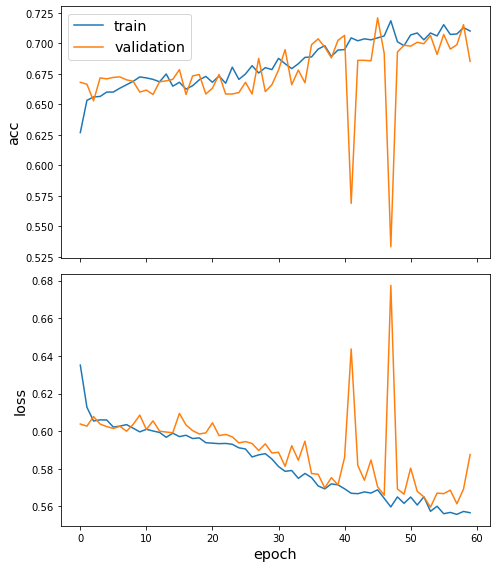

In [ ]:
sg.utils.plot_history(history)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=13)